# Do Specialized Models Outperform a General 'One Model Fits All' Approach in Predictive Analysis?

Many fields have seen substantial benefit from the application of machine learning techniques and the construction of predictive models,including finance, retail and even space exploration to name a few.
For example, in the financial sector predictive models have been instrumental in assisting banks in credit scoring , investment strategies and fraud detection.<br>
The choise of models and machine learning training strategies is crutial to build robust models that can generalize well and deliver the best performance. <br>
However,the optimal strategy for generalization in machine learning remains a contested topic devoid of clear consensus. <br>
Some argue that building a unique specialized model for each task leads to superior performance , while others maintain the belief that generalized models offer a more efficient and robust solution and these models are usually more flexiable and scalable. <br>

In this notebook i plan to systematically investigate these two approaches (generalized vs specialized) and determine which one is more viable under diverce conditions.<br>
This work will not only be benifial for machine learning practitioners but also will help decision-makers across multiple industries. <br>


In [29]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from pycaret.datasets import get_data
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import label_binarize
from joblib import Parallel, delayed
import multiprocessing
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Requirements  :
# !pip install numpy
# !pip install lightgbm
# !pip install pandas
# !pip install scikit-learn
# !pip install pycaret
# !pip install scipy
# !pip install catboost
# !pip install tqdm
# !pip install matplotlib
# !pip install seaborn
# !pip install joblib
# !pip install scipy





'\nrequirements\n!pip install numpy\n!pip install pandas\n!pip install scikit-learn\n!pip install pycaret\n!pip install scipy\n!pip install catboost\n!pip install tqdm\n!pip install matplotlib\n!pip install seaborn\n!pip install joblib\n'

### Data preparation and Exploration


<u>Datasets</u> : <br>
Throughout this investigation i will be considering various real-life datasets from different industries.<br> It's essential to  highlight the versatility of each predictive modeling approach on multiple datasets to draw better conclusions about its performance. Each dataset is unique, having its own specific features, intricacies, and industry-specific knowledge, thus presenting a distinct set of challenges for each approach.
<br>
- credit : This dataset contains credit-related information about different customers and whether they have defaulted on their credit or not.
- telescope : This dataset contains data from astronomical observations that aim to help classify high energy Gamma particles in atmosphere.
- bank : This dataset includes information about bank clients and their banking behavior which will indicate indicate whether a client has made a deposit or not.
- diamond : This dataset is about the characteristics of diamonds such as apparence, clarity etc which will be essential in determining their quality.
- wine : This datasets contains multiple information about the chemical properties of wine and its type (red, white etc).


In [2]:
classification_datasets = {
    'credit': 'default',
    'telescope': 'Class',
    'bank': 'deposit',
    'income': 'income >50K',
    'wine': 'type',
}

In [3]:
Experiement_datasets = pd.DataFrame(list(classification_datasets.items()), columns=['Dataset', 'Target'])
Experiement_datasets

,Dataset,Target
0,credit,default
1,telescope,Class
2,bank,deposit
3,income,income >50K
4,wine,type


In [4]:
#check wether a column is numerical or not in a pandas dataframe
def is_number(series):
  return pd.api.types.is_numeric_dtype(series)

#This functions loads the datafra from pycaret library,performs some preprocessing and returns the data(X,y) 
# and some metadata information (numerical/ categorical columns)

# preprocessing:
# drop any row that contains an null in the corresponding target row
# if the dataset target is not in the numerical form then use the label encoder to fix this issue

def load_dataset(dataset_name):
  """Get dataset."""
  target_name = classification_datasets[dataset_name]
  df = get_data(dataset_name, verbose=False).dropna(subset=[target_name])
  X, y = df.drop(target_name, axis=1), df[target_name]
  num_features = X.columns[X.apply(is_number)].tolist()
  cat_features = [c for c in X.columns if c not in num_features]
  n_classes = len(set(y))
  X.loc[:, cat_features] = X.loc[:, cat_features].fillna("NULL")

  # Convert y to numerical form
  le = LabelEncoder()
  y = le.fit_transform(y)
  y = pd.Series(le.fit_transform(y), index=X.index)


  return X, y, num_features, cat_features, n_classes

In [5]:
dataset_summary = pd.DataFrame(columns=["dataset_name", "num_rows", "num_coulmns","num_classes"])

for index, row in Experiement_datasets.iterrows():
  dataset_name = row['Dataset']
  target_variable = row['Target']
  X, y, _, _, _ = load_dataset(dataset_name)
    
  dataset_summary = dataset_summary.append(pd.Series(
    data=[dataset_name, X.shape[0], X.shape[1], len(set(y))],
    index=dataset_summary.columns
  ),ignore_index=True)
    
dataset_summary

,dataset_name,num_rows,num_coulmns,num_classes
0,credit,24000,23,2
1,telescope,19020,10,2
2,bank,45211,16,2
3,income,32561,13,2
4,wine,6497,12,2


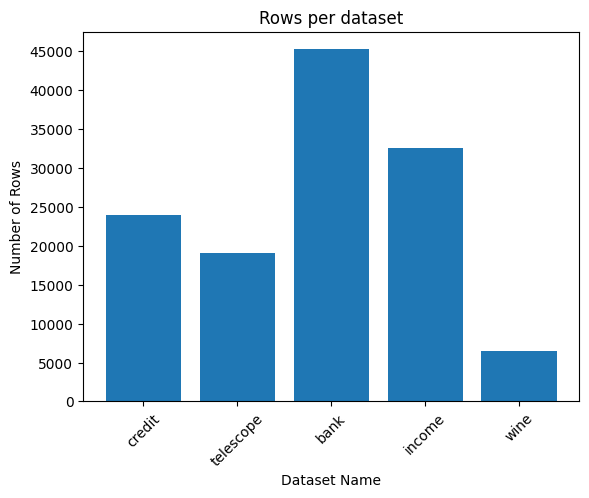

In [6]:
plt.bar(dataset_summary["dataset_name"], dataset_summary["num_rows"])
plt.xlabel('Dataset Name')
plt.ylabel('Number of Rows')
plt.title('Rows per dataset')
plt.xticks(rotation=45)  
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.MultipleLocator(5000))

plt.show()

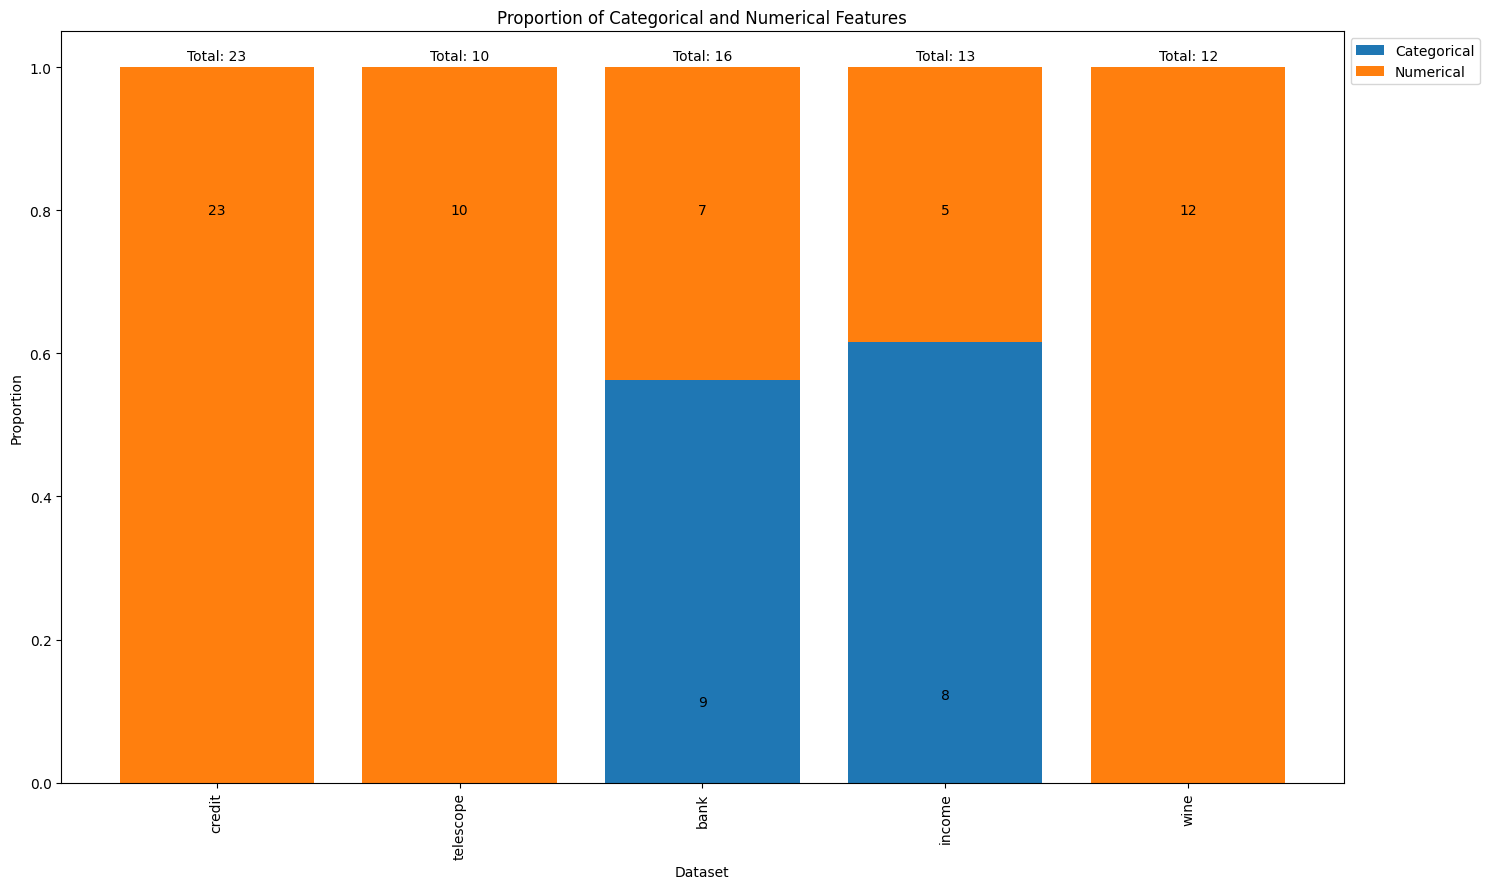

In [7]:

# Create empty lists to store proportions and total features
categorical_proportions = []
numerical_proportions = []
total_features = []
categorical_counts = []
numerical_counts = []
dataset_names = []

# Iterate over each dataset
for index, row in Experiement_datasets.iterrows():
    dataset_name = row['Dataset']
    target_variable = row['Target']
    
    df = get_data(dataset_name, verbose=False)
    categorical_columns = df.select_dtypes(include='object').columns.tolist()
    numerical_columns = df.select_dtypes(exclude='object').columns.tolist()

    # Remove the target variable from the appropriate column list
    if target_variable in categorical_columns:
        categorical_columns.remove(target_variable)
    elif target_variable in numerical_columns:
        numerical_columns.remove(target_variable)
    
    # Calculate the proportions and counts
    categorical_proportion = len(categorical_columns) / (len(categorical_columns) + len(numerical_columns))
    numerical_proportion = len(numerical_columns) / (len(categorical_columns) + len(numerical_columns))
    categorical_count = len(categorical_columns)
    numerical_count = len(numerical_columns)
    
    # Append the proportions, total features, and dataset name to the lists
    categorical_proportions.append(categorical_proportion)
    numerical_proportions.append(numerical_proportion)
    total_features.append(len(categorical_columns) + len(numerical_columns))
    categorical_counts.append(categorical_count)
    numerical_counts.append(numerical_count)
    dataset_names.append(dataset_name)

# Plot the histogram
plt.figure(figsize=(15, 9))
plt.bar(dataset_names, categorical_proportions, label='Categorical')
plt.bar(dataset_names, numerical_proportions, bottom=categorical_proportions, label='Numerical')
plt.xlabel('Dataset')
plt.ylabel('Proportion')
plt.title('Proportion of Categorical and Numerical Features')
plt.xticks(rotation=90)

# Add counts on the bars
for i in range(len(dataset_names)):
    x = i
    y = categorical_proportions[i]
    if categorical_counts[i] > 0:
        plt.text(x, y / 5, f'{categorical_counts[i]}', ha='center', va='center')
    
    x = i
    y = categorical_proportions[i] + numerical_proportions[i]
    if numerical_counts[i] > 0:
        plt.text(x, 4*y / 5, f'{numerical_counts[i]}', ha='center', va='center')
    
    # Add total features as text above the bars
    plt.text(i, categorical_proportions[i] + numerical_proportions[i] + 0.01, f'Total: {total_features[i]}', ha='center')


# Reposition the legend outside the plot
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

plt.tight_layout()
plt.show()


### Data preprocessing

##### Datasets contain both numerical and categorical features:

since we plan to compare the performance of general models vs specialized models, we have to use multiple datasets.<br>

these datasets however contain both numerical and categorical columns so we need a strategy to deal with this issue ,hence it makes sence to implement binning as part of our data preprocessing.<br>
By transforming numerical features into binned categorical features, we can create a more consistent and uniform input structure across different datasets which is vital for this experiment to work.<br>
Binning also helps when it comes to dealing with non-linear relationships between the features and the target variable, which should make it easier for both general and specialized models to capture these relationships. 

Ideally in the real world, this task takes a lot of time and has to be done by qualified data scientists while performing data exploration / analysis to determine the best features and then deal with each data type accordingly.<br>
However in the context of this experiment although may not be ideal, it helps create an automatic and systematic framework for across all datasets and does a decent job at this task. <br>

One possiblity natural follow-up related to binning is how many bins should we use ? <br>
- This where using the elbow-method is really useful as it will help us of determine the optimal number of bins for each dataset and allows us to balance the complexity and interpretability of our data therefore accommodating the inherent variability among different datasets. This approach enables us to maintain the diversity of our datasets while providing a uniform framework for model comparison.

In [8]:

def calculate_wcss(binned_col_2d, nbins):
    """Calculate the within-cluster sum of squares (WCSS) for KMeans clustering."""
    kmeans = KMeans(n_clusters=nbins, random_state=0).fit(binned_col_2d)
    return kmeans.inertia_

# the elbow method is a method that is traditionally used for unsupervised learning problems specifically clustering.It helps us
# determine the optimal number of clusters.
# the basic idea is to keep adding more bins until the added complexity (additional bins ) 
# do not significantly improve the kmeans models performance
def elbow_method(wcss_list):
    """Find the optimal number of bins using the elbow method."""
    dist_points_from_line = []

    for i in range(len(wcss_list)):
        x = i + 2
        y = wcss_list[i]
        x1, y1 = 2, wcss_list[0]
        x2, y2 = len(wcss_list) + 1, wcss_list[-1]

        numerator = abs((y2 - y1) * x - (x2 - x1) * y + x2 * y1 - y2 * x1)
        denominator = np.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2)
        dist_points_from_line.append(numerator / denominator)

    return dist_points_from_line.index(max(dist_points_from_line)) + 2

def binnize(col, max_bins=10):
    """Bin numeric values into discrete intervals with the optimal number of bins using the elbow method."""
    wcss_list = []

    for nbins in range(2, max_bins + 1):
        # Compute the quantiles based on the desired number of bins
        bins = np.linspace(0, 1, nbins + 1)
        quantiles = col.quantile(bins).tolist()

        # Make sure the first bin includes the minimum value
        quantiles[0] -= 1e-10
        quantiles = sorted(set(quantiles))

        # Cut the data into bins based on the quantiles
        binned_col = pd.cut(col, bins=quantiles, include_lowest=True, labels=False)

        # Convert binned data into a 2D array for KMeans clustering
        binned_col_2d = np.array(binned_col).reshape(-1, 1)

        # Calculate the within-cluster sum of squares (WCSS)
        wcss_list.append(calculate_wcss(binned_col_2d, nbins))

    # Find the optimal number of bins using the elbow method
    best_nbins = elbow_method(wcss_list)

    # Use the best number of bins to create the final binned data
    best_bins = np.linspace(0, 1, best_nbins + 1)
    best_quantiles = col.quantile(best_bins).tolist()
    best_quantiles[0] -= 1e-10
    best_quantiles = sorted(set(best_quantiles))
    binned_col_optimal = pd.cut(col, bins=best_quantiles, include_lowest=True)

    return binned_col_optimal


# if a dataframe contains numerical features then transform them into categorical features using binning
def process_numerical_features(data, numerical_features):
    # transform numerical coulmns into categorical columns using binning
    X_transformed = data.copy()
    X_transformed.loc[:, numerical_features] = X_transformed.loc[:, numerical_features].fillna(X_transformed.loc[:, numerical_features].median()).apply(lambda col: col if col.nunique() <= 5 else binnize(col)).astype(str)
    return X_transformed


##### Features selection (for specialized models)

Identifying the best features is a crutial step for training the specialized models because these features essentially define the segments on which the specialized models are trained.
<br>
The biggest argument for specialized models is that once we identify which features are most likely to be relevent for predicting the target variable,we can train specialized models that excel on utilizing those features and get the optimal results.
<br>
For example, if we are working on a dataset that includes information from multiple countries, identifying the 'country' feature as a crucial feature can lead to improved model performance since this will allow us to create a specialized model for each country (The idea is that this specialized model will be tailored to leverage the unique patterns and characteristics of the data for each specific country and hence better performance)

For instance , let's say we are trying to predict the credit default rates.
it's not unresonable to assume that the economic and cultural factors make the patterns of default different in each country.

<br>
<br>
This is why we need to focus on the most relevant features (ones that have a statistical dependence with the target variable) to create more meaningful and diverse segments which in turn can lead to better performing specialized models.

<br> Important Note : If we were to choose irrelevant features, the resulting segments might not reflect any distinct patterns related to the target variable, and as a result, our specialized models might not provide any advantage over the general model.

- This is exactly why the careful selection of these dependent features is key to maximizing the potential of this segmented modeling approach.

In [9]:
def chi_square_test_of_independence(col, target):
    """Perform chi square test between the column and the target then return the p-value.
    p-value informs us whether such an association is statistically significant"""

    #null hypothesis = there is no association between the variables
    crosstab = pd.crosstab(col, target)
    chi2, pvalue, dof, expected = chi2_contingency(crosstab, correction=False)
    return pvalue



def cramers_v(col, target):
    """Calculate Cramer's V coefficient for two categorical arrays.
    cramer's V is a measure of the strength of association between two categorical variables ranging from [0 to 1]"""
    confusion_matrix = pd.crosstab(col, target)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def get_dependent_columns(categorical_data, target, significance_level=0.05, cramer_threshold=0.1):
    """Get the list of columns of categorical_data that are not independent from the target."""
    pvalues = categorical_data.apply(lambda col: chi_square_test_of_independence(col, target))
    v_values = categorical_data.apply(lambda col: cramers_v(col, target))
    dependent_columns = pvalues[(pvalues<significance_level) & (v_values>cramer_threshold)].index.to_list()
    
    return dependent_columns



def select_candidate_values(category_data, target, train_indices, test_indices, segmentation_col, class_count):
    test_value_counts = category_data.loc[test_indices, segmentation_col].value_counts()
    train_unique_values = target.loc[train_indices].groupby(category_data.loc[train_indices, segmentation_col]).nunique()
    test_unique_values = target.loc[test_indices].groupby(category_data.loc[test_indices, segmentation_col]).nunique()

    slection_critiria = (test_value_counts >= 100) & (test_value_counts / len(test_indices) < .5) & (train_unique_values == class_count) & (test_unique_values == class_count)
    selected_values = test_value_counts[slection_critiria].index.to_list()
    
    return selected_values

When we segment data, it's essential to consider several crucial criteria. <br>

- our data segments have to be representative; they have to reflect the diversity and frequency of the categories in the dataset. In my function select_candidate_values, the rule that each category must appears at least 100 times in the test set should help us achieve this representativeness. Although the number 100 is really arbitrary, it's a start to ensure that the segements are not too small.

<br>
<br>


- the association between the categories and the target variable has to be statistically significant. As explained earlier, for this task I will be perform a Chi-square test using the function chi_square_test_of_independence and then filter down to only the columns where the p-value of the test is below a certain significance level (0.05 is the most natural choise). This is done in the select_candidate_values function.
<br>
<br>
- The strength of the association between the categories and our target variable is extremely important, since it helps indicate the predictive power of the categories. For this task, I calculate Cramer's V values and then only select columns whose Cramer's V value exceeds a certain threshold. As a default value for this treshold,i chose 0.1,which can theoritacally guarantee that there is a minor association between the selected categories and the target.I could have been stricter and set the threshold higher but i decided not to do so since i have prepared some other tests later in the experiment to detect if the results that i get are not stastically significant.
<br>
<br>
- in our segments there can't be no single category that overly dominates by making up more than 50% of the test set and also all categories have to be represented to a certain extend (asking for balanced segments is not the correct approach since similar to decision trees the segements don't have to be balanced)
<br>
<br>
By carefully considering these factors, we can construct a systematic segmentation strategy that is statistically sound , doess offer good predictive power, and is relevant and useful in practice.




### Model Training

-For this experiement it's really important to choose machine learning algorithms that can handle categorical data well due to the nature of the data in this experiment.



<u>CatBoost</u>:

CatBoost is a tree based gradient boosting algorithm that works really well with all data types (numerical, categorical, and even text) without extensive prior pre-processing. It's espicially known, for its excelent performance when dealing with categorical features, hence the name catboost.
it uses a different approach than the traditional one-hot-encoding (which can hugely increase the dimentionality of the data by creating a new column for each unique category of a categorical feature) or target based encoding (where we encode each unique category of a categorical feature based on the average of the target corresponding to that category. This approach can be a source of data leakagev and often can lead to overfitting).<br>
Catboost combines both these approaches to create a new method called "Ordered target encoding" which works by calculating the encoded value of each category based on the mean of the target variable up to the given instance in an ordered manner ( where each row's encoding is calculated only from rows before it in the sequence. This way , data leakage is prevented and performance is much more robust)

<br>
Similar to most boosting algorithms catboost creates an ensemble of decision trees , where,sequentially, each newly created tree attempts to correct the errors madde by the privous trees and therefore improving the accuracy each time.
<br>
<br>
<u> Catboost algorithm simplified : </u> <br>
1- The model is initialized with a simple prediction (the mean or simply a constant).<br>
2- The residuals are computed ( residuals = true target - predicted value) <br>
3- A new special type of decision trees called "oblivious trees" (a symmetric tree where all the paths to the leaves have the same length, and each level of the tree corresponds to a decision rule on the same feature for all instances. This reduces the parameters that have to be learned as opposed to regular trees)  is built to predict the residuals (not the actual target). The structure of the tree is determined by selecting splits that minimize the loss function. <br>
4- the predictions are updated =  [the newly predicted residuals *  learning rate + the previous predictions  ]  <br>
5- steps 2-5 are repeated . Each new iteration, a new tree is created to predict the residuals of the current prediction. <br>


<u> Catboost most important parameters : </u> <br>

- Learning rate : controls the speed of learning.
- Depth : Controls the depth of oblivous trees (deeper trees can capture more information by adding more splits but risk overfitting)
- iterations : number of trees in the ensemble .
- l2_leaf_reg : a regularization term to combat overfitting by constraining the model's complexity
- cat_features : one of the most important distingishing features of catboost is its ability to handle categorical data. here we specify a list containing the index of each categorical feature.



<u>LightGBM</u>:
LightGBM is also gradient boosting , tree based algorithm that can is extremely fast and efficient.It's currently one of the best state of the art algorithms and performs constantly well in data-science competitions and the industry. LightGBM also supports both numerical and categorical data (for categorical data further processing might be needed such as one-hot encoding) which makes it a versitile.
<br>
A unique feature of LightGBM, is that unlike its predecessor XGBoost where the decision tree is created using depthwise strategy,LightGBM uses a leaf-wise (best-first) strategy. It does this by choosin the leaf with the maximum loss to grow at each step,. This can potentially result in better accuracy however it's prone to overfitting if not controlled with other parameters.
<br>
<br>
<div style="text-align: center;">
<img src = "https://www.researchgate.net/publication/343566690/figure/fig2/AS:932532258369537@1599344424444/Comparison-between-XGBoost-level-wise-horizontal-tree-growth-and-LightGBM-vertical.png">
</div>

<br>
LightGBM also introduces a new sampling technique known as Gradient-based One-Side Sampling (GOSS).First all the inctances are based on how large their gradients are. Then, GOSS keeps all the instances with large gradients (usualy 20%) and performs random sampling on the instances with small gradients (usually 20% of the remaining 80%). The intuition behind this is that instances with large gradients are harder to learn, which contribute more to the model's learning.
<br>
<br>
<div style="text-align: center;">
<img src="https://i.imgur.com/elUJAZR.png" style="width: 90%; height: 50%;">
</div>

<br>
Similar to most boosting algorithms catboost creates an ensemble of decision trees , where,sequentially, each newly created tree attempts to correct the errors madde by the privous trees and therefore improving the accuracy each time.
<br>
<br>
<u>LightGBM algorithm simplified:</u>

1- Initialize the model with a constant prediction, often the mean of the target.

2- Compute residuals, which are the differences between the true target and current predictions.

3- Build a new tree to predict the residuals, not the target itself. LightGBM uses a leaf-wise growth strategy, selecting the leaf with the maximum delta loss to grow.

4- Update the predictions by adding the newly predicted residuals (multiplied by a learning rate to prevent overfitting) to the previous predictions.

5- Repeat steps 2-4. Each iteration builds a new tree to predict the residuals, which are updated after each iteration.

<u>LightGBM most important parameters:</u>

* learning_rate: Controls the speed of learning.

* num_leaves: This is the main parameter to control the complexity of the tree model.
* max_depth: This parameter specifies the maximum depth to which the tree will grow.
* n_estimators: Number of trees to be built in the ensemble.
* feature_fraction: This parameter specifies the fraction of features to be taken for each tree.
* bagging_fraction and bagging_freq: These parameters are used for bagging to reduce overfitting.
* max_bin: Smaller value of max_bin can save much memory but may slow down the learning process.



In [10]:
def train_general_model_cat(data, target, categorical_features):
    training_indices, test_indices = train_test_split(data.index, test_size=.25, stratify=target,random_state=0)
    general_model = CatBoostClassifier().fit(X=data.loc[training_indices, :], y=target.loc[training_indices], cat_features=categorical_features, silent=True)
    general_predictions = pd.DataFrame(general_model.predict_proba(data.loc[test_indices, :]), index=test_indices, columns=general_model.classes_)
    return training_indices, test_indices, general_predictions


def train_specialized_model_cat(data, data_categorical, target_data, categorical_features, training_set, test_set, column_for_segmentation, specific_value):
    indices_with_value = data_categorical.loc[data_categorical.loc[:, column_for_segmentation] == specific_value, column_for_segmentation].index    
    specialized_training_indices = list(set(indices_with_value).intersection(training_set))
    specialized_test_indices = list(set(indices_with_value).intersection(test_set)) 

    specialized_model = CatBoostClassifier().fit(X=data.loc[specialized_training_indices, :], 
                                                 y=target_data.loc[specialized_training_indices], 
                                                 cat_features=categorical_features, 
                                                 silent=True)

    specialized_predictions = pd.DataFrame(specialized_model.predict_proba(data.loc[specialized_test_indices, :]), 
                                           index=specialized_test_indices, 
                                           columns=specialized_model.classes_)

    return specialized_test_indices, specialized_predictions


In [11]:

from lightgbm import LGBMClassifier
from sklearn.preprocessing import OneHotEncoder

def train_general_model_lgbm(data, target, categorical_features):
    data_encoded = pd.get_dummies(data, columns=categorical_features)
    training_indices, test_indices = train_test_split(data_encoded.index, test_size=.25, stratify=target,random_state=0)
    general_model = LGBMClassifier().fit(X=data_encoded.loc[training_indices, :], y=target.loc[training_indices])
    general_predictions = pd.DataFrame(general_model.predict_proba(data_encoded.loc[test_indices, :]), index=test_indices, columns=general_model.classes_)
    return training_indices, test_indices, general_predictions

def train_specialized_model_lgbm(data, data_categorical, target_data, categorical_features, training_set, test_set, column_for_segmentation, specific_value):
    data_encoded = pd.get_dummies(data, columns=categorical_features)
    indices_with_value = data_categorical.loc[data_categorical.loc[:, column_for_segmentation] == specific_value, column_for_segmentation].index
    specialized_training_indices = list(set(indices_with_value).intersection(training_set))
    specialized_test_indices = list(set(indices_with_value).intersection(test_set))

    specialized_model = LGBMClassifier().fit(X=data_encoded.loc[specialized_training_indices, :], 
                                             y=target_data.loc[specialized_training_indices])

    specialized_predictions = pd.DataFrame(specialized_model.predict_proba(data_encoded.loc[specialized_test_indices, :]), 
                                           index=specialized_test_indices, 
                                           columns=specialized_model.classes_)

    return specialized_test_indices, specialized_predictions

### Evaluation metrics

In [12]:

def get_roc_auc_score(y_true, y_score):
  """Get area under ROC curve.
  ROC Score indicates how well does a model distingish between the target classes
  a perfect classifier has a ROC score of 1
  while a random classifier has a score 0.5
  """
  if y_score.shape[1] == 2:
    return roc_auc_score(y_true, np.array(y_score)[:, 1])
  else:
    # Multi-class problem so we need to use one vs rest approach
    return roc_auc_score(y_true, y_score, multi_class="ovr")
    



### Main Experiement

For each Dataset:
   1. We tranform all numerical columns into categorical
   2. We split it into a train/ test datasets
   3. We train our generalized models on the whole train dataset
   4. On the train dataset we try to find which columns have statistal association with the target variable
   5. We segment our train dataset and test dataset based on those columns
   6. On each segment of the train dataset , we train a specialized model
   7. we evaluate its performance (newly trained specialized model) on the corresponding segment of the test dataset and then also evaluate the performance of the generalized model on the same segment in the test set.
   8. we save the roc_auc score of both the generalized model and specialized models

In [13]:

def evaluate_candidate(dataset_name,model_specialized_train_func, X, X_cat, y, cat_features, ix_train, ix_test, pred_general, segmentation_column, value):
    ix_test_specialized, pred_specialized = model_specialized_train_func(X, X_cat, y, cat_features, ix_train, ix_test, segmentation_column, value)

    roc_auc_score_general = get_roc_auc_score(y.loc[ix_test_specialized], pred_general.loc[ix_test_specialized, :])
    roc_auc_score_specialized = get_roc_auc_score(y.loc[ix_test_specialized], pred_specialized)

    # Save the actual prediction scores of both models
    pred_general_scores = pred_general.loc[ix_test_specialized, :]
    pred_specialized_scores = pred_specialized

    # Save the true labels
    true_labels = y.loc[ix_test_specialized]

    result = {
        "dataset": dataset_name,
        "column": segmentation_column,
        "value": value,
        "count": len(ix_test_specialized),
        "distr": y.loc[ix_test_specialized].value_counts().to_list(),
        "roc_general": roc_auc_score_general,
        "roc_specialized": roc_auc_score_specialized,
        "pred_general_scores": pred_general_scores,
        "pred_specialized_scores": pred_specialized_scores,
        "true_labels": true_labels,
    }

    return result




def evaluate_dataset(dataset_name,num_cores):
    X, y, numerical_features, categorical_features, n_classes_target = load_dataset(dataset_name)

    train_indices_lgbm, test_indices_lgbm, pred_general_lgbm = train_general_model_lgbm(X, y, categorical_features)
    train_indices_cat, test_indices_cat, pred_general_cat = train_general_model_cat(X, y, categorical_features)

    X_cat = process_numerical_features(X, numerical_features)
    candidate_columns = get_dependent_columns(X_cat, y)

    results_df = pd.DataFrame(columns=["dataset", "column", "value", "count", "distr", "roc_general", "roc_specialized","pred_general_scores","pred_specialized_scores","true_labels"])


    for segmentation_column in candidate_columns:
        candidate_values_lgbm = select_candidate_values(X_cat, y, train_indices_lgbm,test_indices_lgbm, segmentation_column, n_classes_target)
        candidate_values_cat = select_candidate_values(X_cat, y, train_indices_cat,test_indices_cat, segmentation_column, n_classes_target)

        results1 = Parallel(n_jobs=num_cores)(
            delayed(evaluate_candidate)(dataset_name,train_specialized_model_lgbm, X, X_cat, y, categorical_features, train_indices_lgbm, test_indices_lgbm, pred_general_lgbm, segmentation_column, condidate_value) 
            for condidate_value in candidate_values_lgbm)

        results2 = Parallel(n_jobs=num_cores)(
            delayed(evaluate_candidate)(dataset_name,train_specialized_model_cat, X, X_cat, y, categorical_features, train_indices_cat, test_indices_cat, pred_general_cat, segmentation_column, condidate_value) 
            for condidate_value in candidate_values_cat)

        for result in results1 + results2:
            results_df = results_df.append(result, ignore_index=True)

    return results_df

def main():
    dataset_names = Experiement_datasets["Dataset"].values
    num_cores = multiprocessing.cpu_count()

    results = Parallel(n_jobs=num_cores)(
        delayed(evaluate_dataset)(dataset_name,num_cores) for dataset_name in tqdm(dataset_names))
    
    results_df = pd.concat(results, ignore_index=True)

    return results_df


results = pd.DataFrame(columns=["dataset", "column", "value", "count", "distr", "roc_general", "roc_specialized","pred_general_scores","pred_specialized_scores","true_labels"])
results = main()

  0%|          | 0/5 [00:00<?, ?it/s]

In [14]:
results


,dataset,column,value,count,distr,roc_general,roc_specialized,pred_general_scores,pred_specialized_scores,true_labels
0,credit,LIMIT_BAL,"(190000.0, 240000.0]",806,"[680, 126]",0.770279,0.724761,0 1 16384 0.924376 0.0...,0 1 16384 0.920887 0.0...,16384 0 20481 0 22529 1 22536 0 20...
1,credit,LIMIT_BAL,"(9999.999, 30000.0]",796,"[519, 277]",0.733875,0.704611,0 1 10241 0.855981 0.1...,0 1 10241 0.930374 0.0...,10241 0 2051 1 14340 1 4106 0 14...
2,credit,LIMIT_BAL,"(50000.0, 90000.0]",753,"[536, 217]",0.746815,0.720141,0 1 22530 0.889211 0.1...,0 1 22530 0.905011 0.0...,22530 0 12292 0 2054 0 6154 0 16...
3,credit,LIMIT_BAL,"(240000.0, 340000.0]",745,"[623, 122]",0.728903,0.676447,0 1 12289 0.955589 0.0...,0 1 12289 0.997648 0.0...,12289 0 14339 0 10245 0 18439 0 20...
4,credit,LIMIT_BAL,"(90000.0, 140000.0]",740,"[561, 179]",0.817774,0.779155,0 1 18434 0.942590 0.0...,0 1 18434 0.988685 0.0...,18434 0 12291 0 12293 1 2060 0 14...
...,...,...,...,...,...,...,...,...,...,...
595,wine,quality,"(2.999, 5.0]",558,"[382, 176]",0.999866,0.999955,0 1 4096 0.000037 0.999...,0 1 4096 0.000031 0.999...,4096 1 4101 1 11 0 2068 1 23 ...
596,wine,quality,"(6.0, 9.0]",334,"[266, 68]",1.000000,1.000000,0 1 2048 0.000058 0.999...,0 1 2048 0.000093 0.999...,2048 1 2053 1 7 0 6158 1 6161 ...
597,wine,quality,"(5.0, 6.0]",733,"[577, 156]",0.999722,0.999600,0 1 2054 0.016647 0.983...,0 1 2054 0.005212 0.994...,2054 1 4103 1 6152 1 6153 1 4105 ...
598,wine,quality,"(2.999, 5.0]",558,"[382, 176]",0.999926,0.999881,0 1 4096 0.000396 0.999...,0 1 4096 0.000627 0.999...,4096 1 4101 1 11 0 2068 1 23 ...


In [15]:
def convert_to_labels(row):
    pred_specialized_labels = row["pred_specialized_scores"].idxmax(axis=1).values
    pred_generalized_labels = row["pred_general_scores"].idxmax(axis=1).values

    true_labels = row["true_labels"].values
    return pd.Series({"pred_specialized_scores": pred_specialized_labels,"pred_general_scores":pred_generalized_labels ,"true_labels": true_labels})


results[["pred_general_scores","pred_specialized_scores","true_labels"]]=results.apply(convert_to_labels, axis=1)

### Result interpretation

The ROC AUC score is a widely used metric in classification tasks which informs us about the performance of a binary classifier. It provides us insight about of how well the model distinguishes between positive and negative samples, with higher scores indicating better classification performance.<br>
However comparing the ROC AUC scores of two models directly may not provide a statistically rigorous comparison (generalized vs specialized models) and this exactly why doing a DeLong test is crutial as it will inform us about wether the observed difference in the ROC scores is statistically significant.<br>
The DeLong test takes into account the correlation between the predictions of the two models and calculates a p-value that indicates the likelihood of observing the observed difference in AUC scores under the null hypothesis of no difference.<br>
We can then easily interpret the result p_value, for example if the p_value is bellow 5% , it's very unlikely that the observed differences in the performance is simply due to sheer luck.


In [16]:
# I HAVE NOT WRITTEN THIS CODE.
# I HAVE SIMPLY COPIED IT HERE FROM A LIBRARY FOR THE PURPOSE OF GUARANTYING A RIGOROUS SCIENTIFIC ANALYSIS
# code source : https://github.com/yandexdataschool/roc_comparison/blob/master/compare_auc_delong_xu.py

import pandas as pd
import numpy as np
import scipy.stats


def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Operating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=float)
    ty = np.empty([k, n], dtype=float)
    tz = np.empty([k, m + n], dtype=float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov


def calc_pvalue(aucs, sigma):
    """Computes log(10) of p-values.
    Args:
       aucs: 1D array of AUCs
       sigma: AUC DeLong covariances
    Returns:
       log10(pvalue)
    """
    l = np.array([[1, -1]])
    z = np.abs(np.diff(aucs)) / np.sqrt(np.dot(np.dot(l, sigma), l.T))
    return np.log10(2) + scipy.stats.norm.logsf(z, loc=0, scale=1) / np.log(10)


def compute_ground_truth_statistics(ground_truth):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (-ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    return order, label_1_count


def delong_roc_variance(ground_truth, predictions):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov


def delong_roc_test(ground_truth, predictions_one, predictions_two):
    """
    Computes log(p-value) for hypothesis that two ROC AUCs are different
    Args:
       ground_truth: np.array of 0 and 1
       predictions_one: predictions of the first model,
          np.array of floats of the probability of being class 1
       predictions_two: predictions of the second model,
          np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = np.vstack((predictions_one, predictions_two))[:, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    return calc_pvalue(aucs, delongcov)

In [27]:
def evaluate(results):
  # Transform data to improve clarity

  results["p_value"] = results.apply(lambda row: 
                                      delong_roc_test(row["true_labels"], row["pred_general_scores"], row["pred_specialized_scores"]), 
                                      axis=1)
  
  # If p_value < 0.05, we reject the null hypothesis and consider the difference to be statistically significant
  results["roc_diff_hp"] = results["p_value"].apply(lambda x: "significant" if x < 0.05 else "not significant")
  
  results["compare"] = (results["roc_general"] >= results["roc_specialized"]).map({
    True: "general > specialized",
    False: "specialized > general"
  })

  # Create a DataFrame for significant results
  significant_results = results[results["roc_diff_hp"] == "significant"]

  # Define min and max roc for setting graph limits
  min_roc = significant_results[["roc_general","roc_specialized"]].values.min()
  max_roc = significant_results[["roc_general","roc_specialized"]].values.max()


  # Compute summary statistics
  n_total = len(significant_results)
  n_specialized_better = sum(significant_results["compare"] == "specialized > general")
  n_general_better = sum(significant_results["compare"] == "general > specialized")
  perc_specialized_better = n_specialized_better / n_total * 100
  perc_general_better = n_general_better / n_total * 100

  average_improvement = significant_results.loc[significant_results["compare"] == "specialized > general", "roc_specialized"].mean() - \
                        significant_results.loc[significant_results["compare"] == "specialized > general", "roc_general"].mean()

  average_decrease = significant_results.loc[significant_results["compare"] == "general > specialized", "roc_specialized"].mean() - \
                    significant_results.loc[significant_results["compare"] == "general > specialized", "roc_general"].mean()

  # Print summary statistics
  print(f"Specialized model performs better in {n_specialized_better} out of {n_total} cases ({perc_specialized_better:.1f}%)")
  print(f"General model performs better in {n_general_better} out of {n_total} cases ({perc_general_better:.1f}%)")
  print(f"Average improvement in ROC score when specialized model is better: {average_improvement:.3f}")
  print(f"Average decrease in ROC score when specialized model is worse: {average_decrease:.3f}")


  # Compute the mean difference between the general and specialized models' ROC scores
  mean_difference = (significant_results["roc_general"] - significant_results["roc_specialized"]).mean()

  # Convert to percentage
  mean_difference_percentage = mean_difference * 100

  print(f"The mean difference in ROC scores between the general and specialized models in significant cases is {mean_difference_percentage:.1f}%.")

  # Subplot 1: Pie chart
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

  labels = 'Specialized Better', 'General Better'
  sizes = [n_specialized_better, n_general_better]
  colors = ['#ff9999','#66b3ff']

  ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
  ax1.set_title('Model Performance Comparison For Statistically Significant Cases', fontsize=14)

  #draw circle
  centre_circle = plt.Circle((0,0),0.70,fc='white')
  fig = plt.gcf()
  fig.gca().add_artist(centre_circle)

  # Equal aspect ratio ensures that pie is drawn as a circle.
  ax1.axis('equal')  

  # Subplot 2: Bar chart
  labels = ['Specialized Better', 'General Better']
  roc_difference = [average_improvement, -average_decrease]
  colors = ['#ff9999','#66b3ff']

  ax2.bar(labels, roc_difference, color=colors)
  ax2.set_xlabel('Model Performance', fontsize=14)
  ax2.set_ylabel('Average ROC difference', fontsize=14)
  ax2.set_title('Average ROC score difference', fontsize=14)

  # Set yticks
  max_y = max(roc_difference) + 0.1  # Add a little extra space at the top
  ax2.set_yticks(np.arange(0, max_y, 0.1))

  ax2.grid(True)

  # Display the plot
  plt.tight_layout()
  plt.show()






Specialized model performs better in 61 out of 550 cases (11.1%)
General model performs better in 489 out of 550 cases (88.9%)
Average improvement in ROC score when specialized model is better: 0.004
Average decrease in ROC score when specialized model is worse: -0.020
The mean difference in ROC scores between the general and specialized models in significant cases is 1.7%.


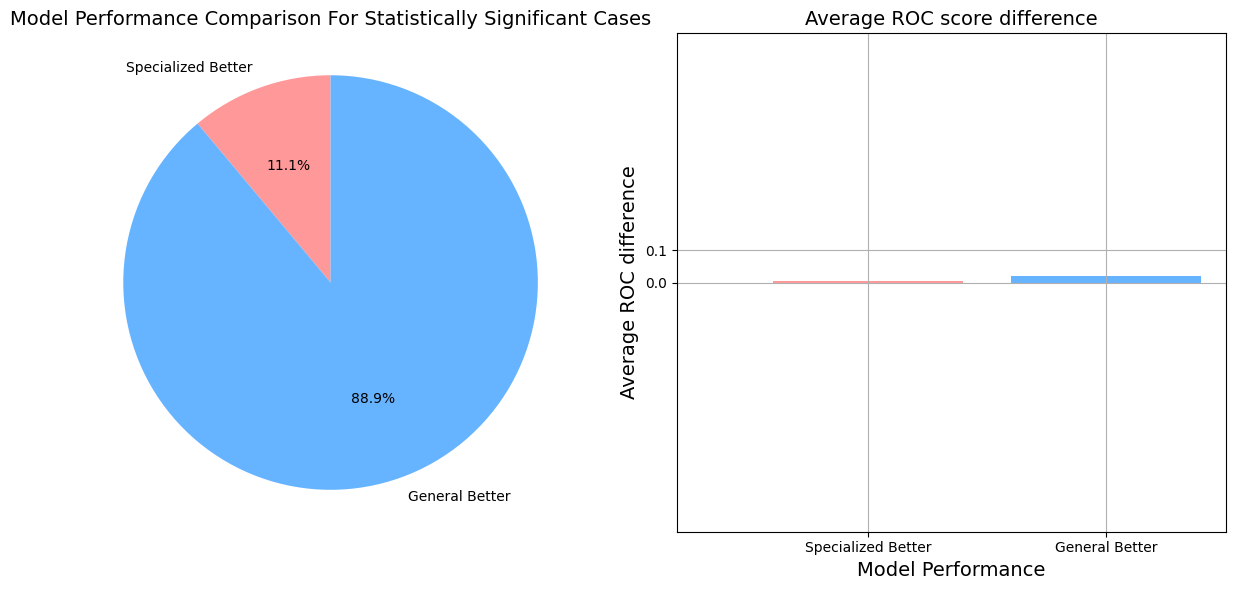

In [28]:
evaluate(results)

## conclusion

In conclusion, after having tested the performance (ROC_AUC) of 550 machine learning models, using 2 different machine learning algorithms (CatBoost and LGBMBoost) across 5 datasets (from different sectors), It's to assume, that although specialized models can deliver great predictive performance, there's no reason to only focus on this using paradigm and that generalized model do offer robust and comparable and even better performances  most of the time. (88.9%) <br>
In fact, the mean difference in ROC scores between the general and specialized models in significant cases is 1.7% which is  not negligeable.
It's also important to mention that specialized models  :
- can be much harder to maintain espicially when the training data is not static
- can be significantly more complex


## References :

1- CatBoost: gradient boosting with categorical features support
Anna Veronika Dorogush, Vasily Ershov, Andrey Gulin Yandex - http://learningsys.org/nips17/assets/papers/paper_11.pdf

2- LightGBM: A Highly Efficient Gradient Boosting
Decision Tree - https://proceedings.neurips.cc/paper_files/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf

3- CatBoost vs. Light GBM vs. XGBoost : https://medium.com/towards-data-science/catboost-vs-light-gbm-vs-xgboost-5f93620723db

4- Comparison between XGBoost level-wise horizontal tree growth and LightGBM vertical leaf-wist tree growth.
 Available from: https://www.researchgate.net/figure/Comparison-between-XGBoost-level-wise-horizontal-tree-growth-and-LightGBM-vertical_fig2_343566690

5- What is the DeLong test for comparing AUCs? https://statisticaloddsandends.wordpress.com/2020/06/07/what-is-the-delong-test-for-comparing-aucs/ 
